In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats.qmc as scp
from multiprocess import Pool

In [21]:
def main(s, max_iter=300, sequence=None, sampling='random', np=np, scp=scp):

    real_min = -2
    real_max = 1
    im_min = -1.5
    im_max = 1.5

    width = real_max - real_min
    height = im_max - im_min

    real_mean = -0.5
    real_std = 1
    im_mean = 0
    im_std = 1
    
    rng = np.random.default_rng(sequence)

    def generate_sample():

        complex_arr = np.zeros(s, dtype=complex)

        if sampling == 'random':
            sample = rng.uniform(size=(s, 2))

        elif sampling == 'LHS':
            Latin = scp.LatinHypercube(d = 2, seed=rng)
            sample = Latin.random(n = s)

        elif sampling == 'ortho':
            sample = np.zeros((s, 2))
            Latin = scp.LatinHypercube(d = 2, seed=rng)
            current_index = 0
            if s < 1e4:
                spaces = 100
            else:
                spaces = 10000

            sub_s = int(round(s / spaces, 0))
            n = int(np.sqrt(spaces))
            sub_width = width / n
            sub_height = height / n

            sub_real_min = real_min
            sub_real_max = real_min + sub_width
            sub_im_max = im_max
            sub_im_min = im_max - sub_height

            # sample equivalent regions in whole space from left right, top to bottom
            for vert_space in range(n):
                for hor_space in range(n):
                    sub_sample = Latin.random(n = sub_s)
                    # print(sub_sample)
                    sample[current_index:(current_index + sub_s)] = scp.scale(sub_sample, [sub_real_min, sub_im_min], [sub_real_max, sub_im_max])
                    sub_real_min = sub_real_max
                    sub_real_max += sub_width
                    current_index += sub_s
                    
                sub_real_min = real_min
                sub_real_max = real_min + sub_width
                sub_im_max = sub_im_min
                sub_im_min -= sub_height

        elif sampling == 'importance':
            real_sample = rng.normal(real_mean, real_std, size=s)
            im_sample = rng.normal(im_mean, im_std, size=s)
            

        if sampling != 'importance':
            try:
                sample = scp.scale(sample, [real_min, im_min], [real_max, im_max])
            except ValueError:
                pass
            for i in range(s):    
                complex_arr[i] = complex(sample[i,0], sample[i,1])

        else:
            for i in range(s):
                complex_arr[i] = complex(real_sample[i], im_sample[i])
            
        return complex_arr

    def f(z, c):
        return z**2 + c

    def iterate(c):
        iter = 0
        z = 0
        while abs(z) <= 2 and iter < max_iter:
            z = f(z, c)
            iter += 1
        return iter

    def inv_Gaussian_distr(x, mean, std):
        return (np.sqrt(2 * np.pi * std ** 2)) / np.exp(-(((x - mean) ** 2) / (2 * std ** 2)))

    iterations = []
    for j in range(max_iter):
        iterations.append([]) 

    complex_list = generate_sample()
    for c in complex_list:
        iter = iterate(c)
        iterations[iter-1].append(c)

    
    # calculate area from fraction non-diverged points
    if sampling == 'importance':
        weights = inv_Gaussian_distr(np.real(iterations[-1]), real_mean, real_std) * inv_Gaussian_distr(np.imag(iterations[-1]), im_mean, im_std)
        A = sum(weights) / s

    else:
        A = (real_max - real_min) * (im_max - im_min) * len(iterations[-1])/ s
    
    return iterations, A

In [4]:
if __name__ == "__main__":
    s = 1000000
    n = 50
    max_iter = 300
    max_iters = np.full(n, max_iter)
    s = np.full(n, s)

    seq = np.random.SeedSequence()
    seeds = seq.spawn(n)

    args = list(zip(s, max_iters, seeds))
    results = []
    area = []
    with Pool() as p:
        for result, A in p.starmap(main, args):
            results.append(result)
            area.append(A)

    # convert results to single list for faster plotting
    data = [None] * max_iter
    for subset in results:
        
        for it in range(len(subset)):
            try:
                data[it] += subset[it]
            except TypeError:
                data[it] = subset[it]

In [4]:
def visualise(data, max_iter):
    fig = plt.figure(dpi=600)
    ax = fig.add_subplot(111)

    cmap = plt.cm.nipy_spectral_r
    norm = plt.Normalize(vmin=1, vmax=max_iter)
    plt.ylim(-1.2, 1.2)
    plt.xlim(-2, 1)
    i = 0

    for it in data:
        i += 1
        x = np.real(np.array(it))
        y = np.imag(np.array(it))
        ax.scatter(x, y, lw=0, s=1*(72/fig.dpi)**2, color=cmap(norm(i)))

    plt.title('Visualisation of the Mandelbrot set')
    plt.xlabel('$Re_c$')
    plt.ylabel('$Im_c$')
    fig.savefig('mandelbrot_50mil_300i_backup.png', dpi=600)
    plt.show()

In [16]:
print(len(area))
print(np.mean(area))
print(np.std(area, ddof=1))

50
1.5206848199999998
0.0037437706174826718


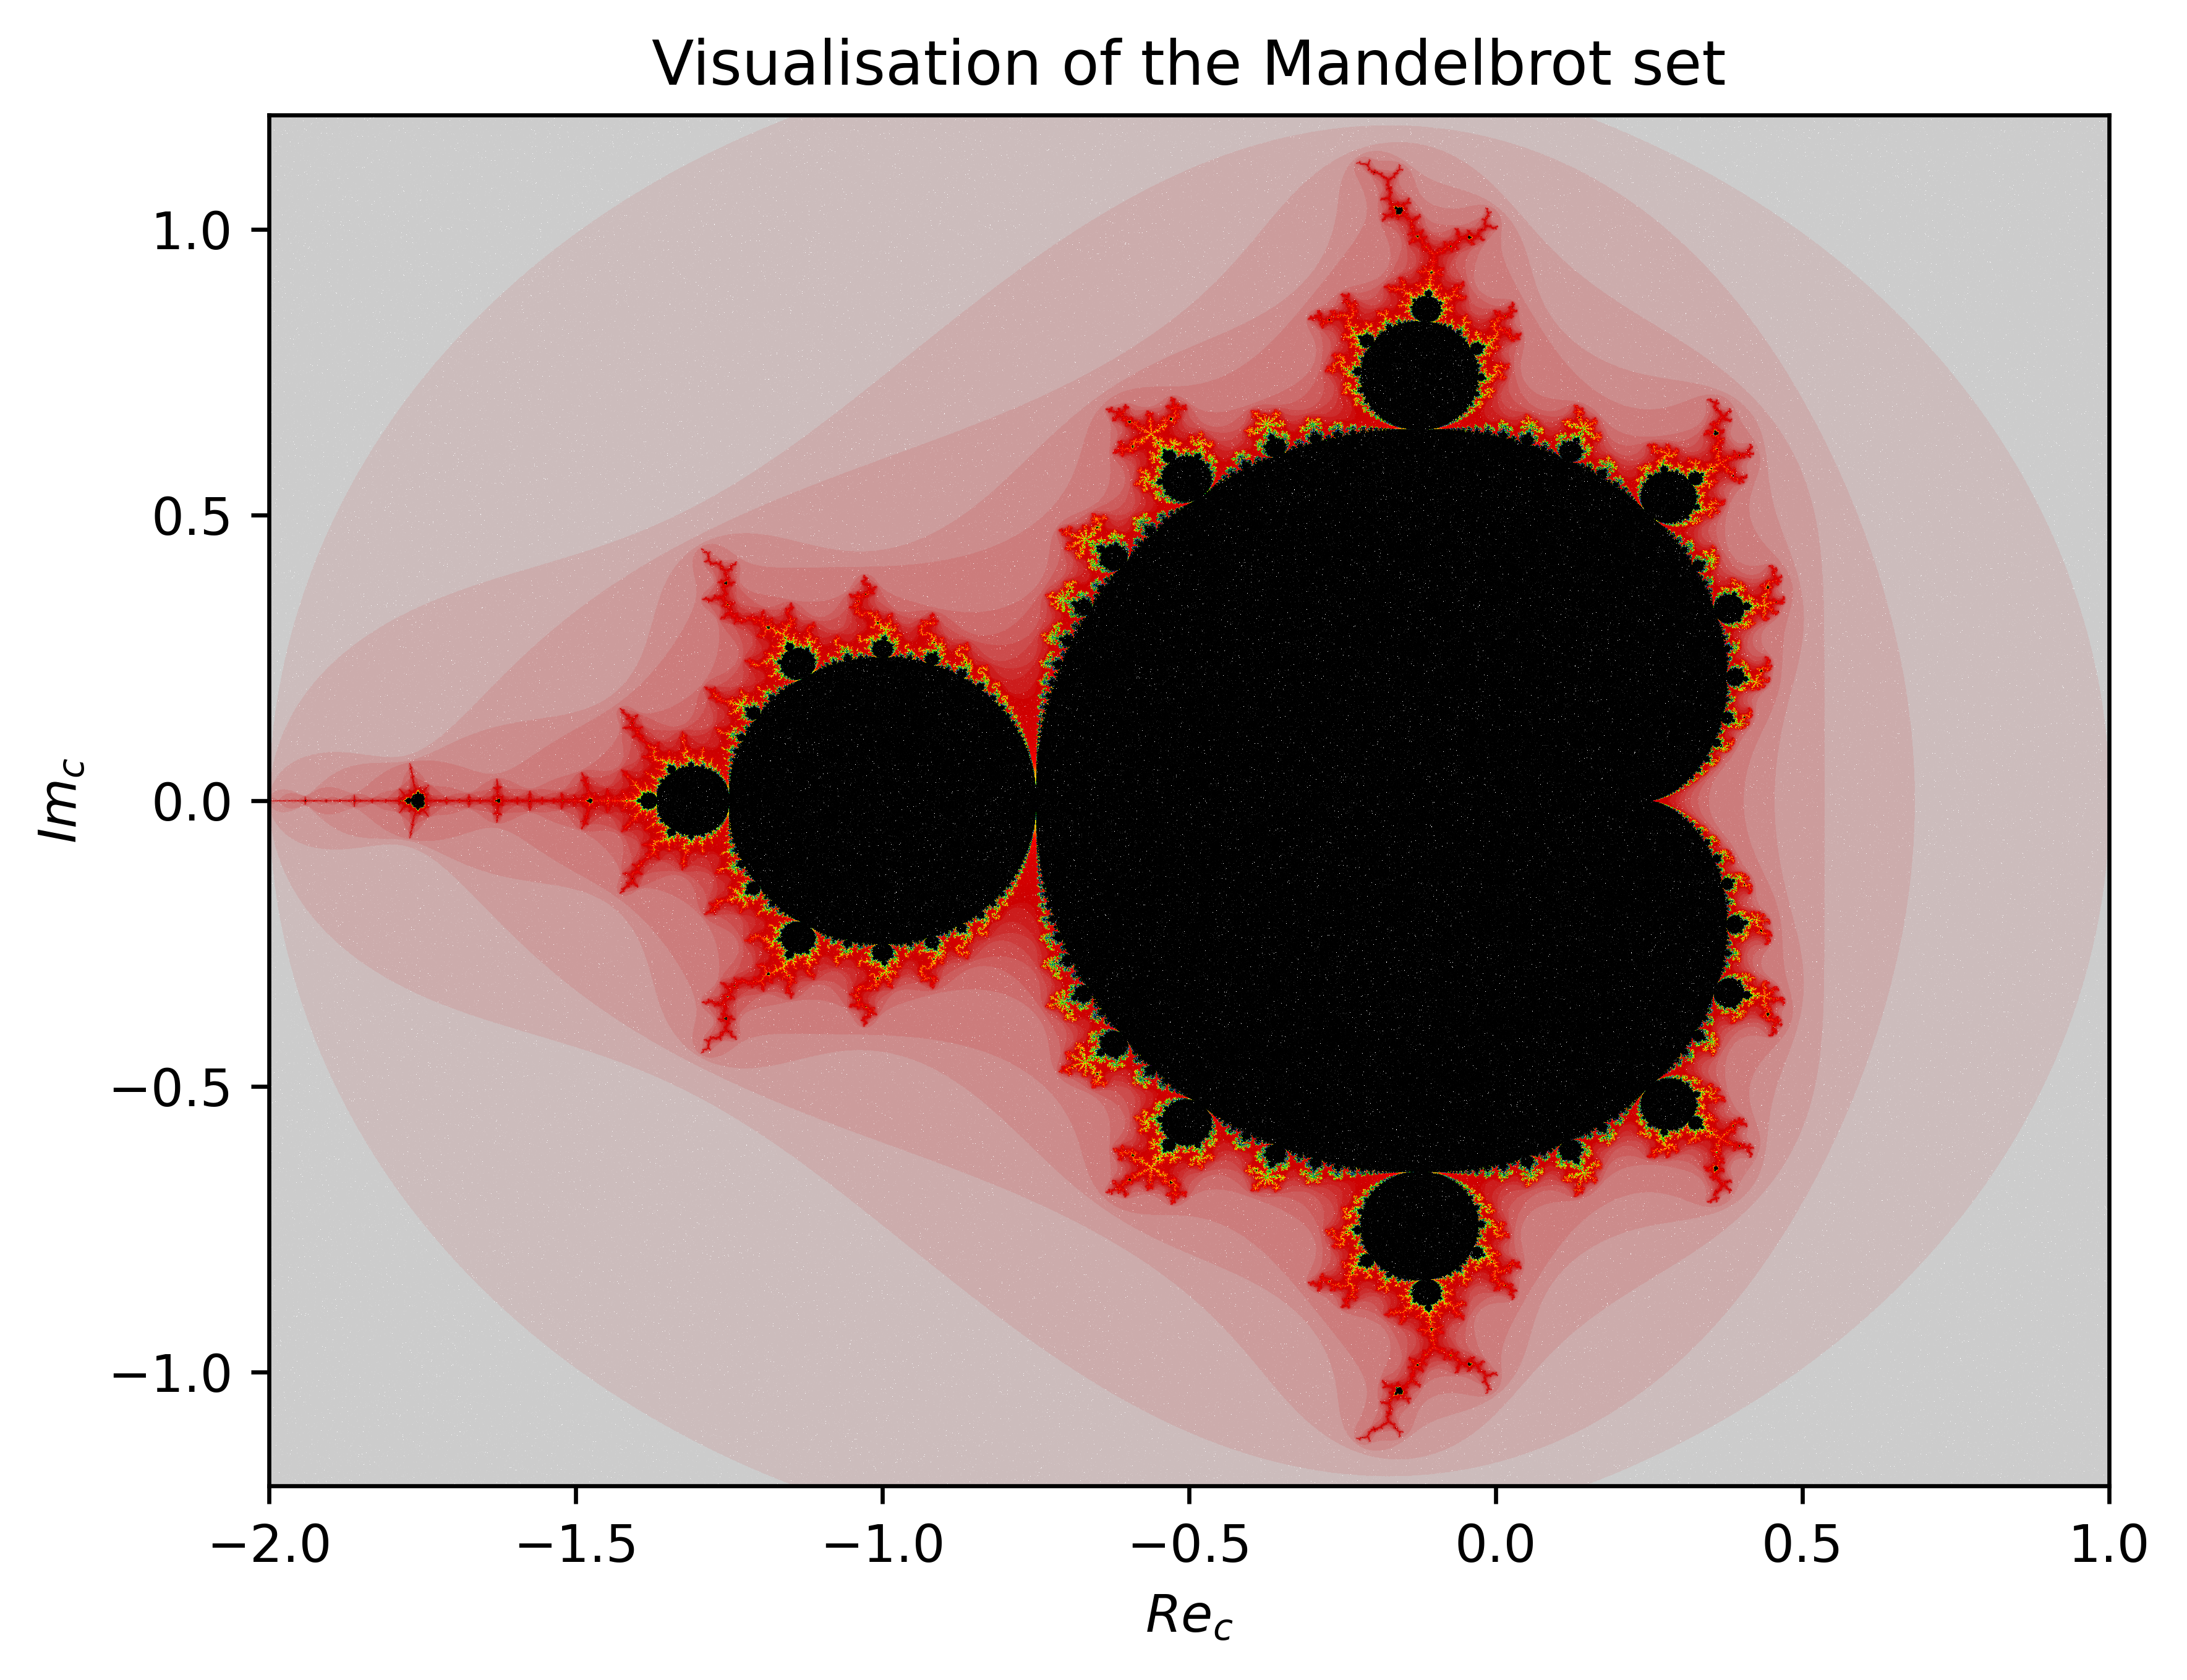

In [21]:
visualise(data, max_iter)

In [ ]:
json_list = []
with open(f"results.json", 'w') as f:
    for iter in data:
        iter_list = []
        for c in iter:
            iter_list.append((np.real(c), np.imag(c)))
        json_list.append(iter_list)

    f.write(json.dumps(json_list))

In [ ]:
# runs main a number of times and finds mean and 95% conf. int
# def loop(runs, s, max_iter, sequence, main=main):
#     sub_sequence = sequence.spawn(10)
#     area_list = []
#     for i in range(runs):
#         iterations, A = main(s, max_iter, sub_sequence[i])
#         area_list.append(A)
    
#     return area_list

In [ ]:
# if __name__ == "__main__":
#     s = 10000
#     chunks = 10
#     runs = 5
#     max_iter = 300
#     max_iters = np.full(chunks, max_iter)
#     s_list = np.full(chunks, s)
#     runs_list = np.full(chunks, runs)

#     # independent seeds necessary for parallel processing
#     seq = np.random.SeedSequence()
#     sequences = seq.spawn(chunks)


#     args = list(zip(runs_list, s_list, max_iters, sequences))
#     with Pool() as p:
#         results =  p.starmap(loop, args)
    
#     data = [None] * runs
#     for chunk in results:
#         for element in range(len(chunk)):
#             try:
#                 data[element] += [chunk[element]]
#             except TypeError:
#                 data[element] = [chunk[element]]
    

In [5]:
# this function finds the average for different number of max iter (and a fixed number of samples)
# run amount is the amount of runs we will find mean of

def converge_i(s, domain, sequence=None, sampling='random', main=main):
    difference = []
    upper = []
    lower = []

    data = []
    child_sequence = sequence.spawn(len(domain))
    
    for i in range(len(domain)):
        max_iter = domain[i]
        iterations, A = main(s, max_iter, child_sequence[i], sampling)
        data.append((max_iter, A))
    

    return data
# converge_i(10, 50, 550, 50)

In [14]:
def analyse(results, var_range, variable):

    data = np.zeros((len(results), 5))

    for sim in range(len(results)):
        # print(results[sim])
        
        var = var_range[sim]
        min_area = np.min(results[sim])
        
        mean_area = np.mean(results[sim])
        max_area = np.max(results[sim])
        # print(f"Mean area = {mean_area}") 
        std = np.std(results[sim])  
        differ = 1.96 * std / (np.sqrt(len(results[sim])))
        # print(f"1.96 * standard error = {differ}")
        min_range = mean_area - differ
        max_range = mean_area + differ

        # print(f"range = [{min_range, max_range}]\n" )
        data[sim] = [var, min_area, mean_area, max_area, std]

    if variable == 's':
        x = data[:,0]
        y = data[:,-1]
        plt.xscale('log')
    elif variable == 'i':
        x = data[:,0]
        y = data[:,2]
        min = data[:, 1]
        max = data[:, 3]
        # plt.plot(x, min, c='green')
        # plt.plot(x, max, c='red')
    
    plt.plot(x, y)

    plt.show()

In [33]:
def analyse2(results, var_range):

    data = np.zeros((len(results), 6))

    for sim in range(len(results)):
        var = var_range[sim]
        min_area = np.min(results[sim])
        mean_area = np.mean(results[sim])

        max_area = np.max(results[sim])
        # print(f"Mean area = {mean_area}") 
        std = np.std(results[sim])  
        differ = 1.96 * std / (np.sqrt(len(results[sim])))
        # print(f"1.96 * standard error = {differ}")
        min_range = mean_area - differ
        max_range = mean_area + differ

        # print(f"range = [{min_range, max_range}]\n" )
        data[sim] = [var, min_area, mean_area, max_area, std, differ]
     



    fig = plt.figure(figsize=(4,3), dpi = 300)
    x = data[:,0]
    y = data[:,2]
    yerr = data[:,-1]
    plt.xscale('log')

    # fig = plt.figure(figsize=(4,3), dpi = 300)
    # x = data[:,0]/1000000
    # y = data[:,2]
    # yerr = data[:,-1]
    plt.plot(x,y, color = 'k')
    #plt.errorbar(x, y, yerr = yerr, color='k', ecolor = 'r', capsize = 5)
    plt.fill_between(x, y - yerr, y + yerr, color = 'g', alpha = 0.3)
    #plt.xlabel("Number of Iterations")
    plt.xlabel("Number of Samples (in millions)")
    plt.ylabel("Mean Area")
    plt.show()





    # print(area_list)
    # diff = mean_area - 0

    # std = np.std(area_list)
    # error = 1.96*std/(np.sqrt(run_amount))
    # min_range = mean_area - error
    # max_range = mean_area + error

    # difference.append(diff)
    # upper.append(min_range)
    # lower.append(max_range)
        
 


    

In [ ]:
if __name__ == "__main__":
    s = 100000
    
    chunks = 25
    
    min_iter = 75
    max_iter = 1500
    steps = 15

    
    max_iters = np.full(chunks, max_iter)
    s_list = np.full(chunks, s)
    # runs_list = list(np.full(chunks, runs))

    iter_range = np.linspace(min_iter, max_iter, steps, dtype=int)
    iter_ranges = np.repeat([iter_range], chunks, axis=0)
    # print(domains)

    # independent seeds necessary for parallel processing
    seq = np.random.SeedSequence()
    sequences = seq.spawn(chunks)
    
    args = list(zip(s_list, iter_ranges, sequences))
    
    with Pool() as p:
        results =  np.array(p.starmap(converge_i, args))
    
    i_data = [None] * steps
    for step in range(steps):
        i_data[step] = results[:,step, 1]

In [ ]:
analyse(i_data, iter_range, 'i')

In [7]:
# this function finds the average for different number of max iter (and a fixed number of samples)
# run amount is the amount of runs we will find mean of

def converge_s(s_range, max_iter, sequence=None, sampling='random', main=main):
    difference = []
    upper = []
    lower = []

    data = []
    child_sequence = sequence.spawn(len(s_range))
    
    for i in range(len(s_range)):
        s = s_range[i]
        iterations, A = main(s, max_iter, child_sequence[i], sampling)
        data.append((s, A))
    

    return data

In [10]:
if __name__ == "__main__":

    min_log_s = 2
    max_log_s = 6
    steps = 10
    chunks = 25

    s_range = np.logspace(min_log_s, max_log_s, steps, dtype=int)
    s_ranges = np.repeat([s_range], chunks, axis=0)

    max_iter = 200
    max_iters = np.full(chunks, max_iter)

    # independent seeds necessary for parallel processing
    seq = np.random.SeedSequence()
    sequences = seq.spawn(chunks)
    
    args = list(zip(s_ranges, max_iters, sequences))

    with Pool() as p:
        results =  np.array(p.starmap(converge_s, args))
    
    s_data = [None] * steps
    for step in range(steps):
        s_data[step] = results[:,step, 1]



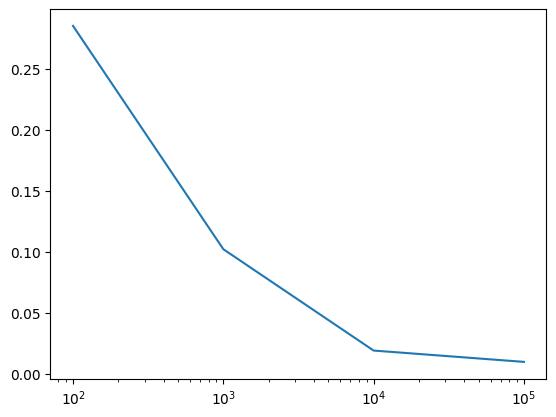

In [15]:
analyse(s_data, s_range, 's')

In [23]:
if __name__ == "__main__":

    s_sampling_results = {}

    min_log_s = 2
    max_log_s = 6
    s_steps = 10
    chunks = 25

    


    s_range = np.logspace(min_log_s, max_log_s, s_steps, dtype=int)
    s_range = np.array([(np.ceil(s / 100) * 100) for s in s_range], dtype=int)

    # s range that is guaranteed to work with orthogonal sampling
    s_range = np.array([100, 300, 800, 2200, 6000, 20000, 50000, 130000, 360000, 1000000], dtype=int)
    print(s_range)

    s_ranges = np.repeat([s_range], chunks, axis=0)

    max_iter = 200
    max_iters = np.full(chunks, max_iter)

    for sampling in ['ortho', 'importance']:
        print(sampling)
        samplings = np.full(chunks, sampling)

        # independent seeds necessary for parallel processing
        seq = np.random.SeedSequence()
        sequences = seq.spawn(chunks)
        
        args = list(zip(s_ranges, max_iters, sequences, samplings))
        with Pool() as p:
            s_results =  np.array(p.starmap(converge_s, args))
            pass

        
        s_data = [None] * s_steps
        for step in range(s_steps):
            s_data[step] = s_results[:,step, 1]
        
        s_sampling_results[sampling] = s_data



[    100     300     800    2200    6000   20000   50000  130000  360000
 1000000]
ortho
importance


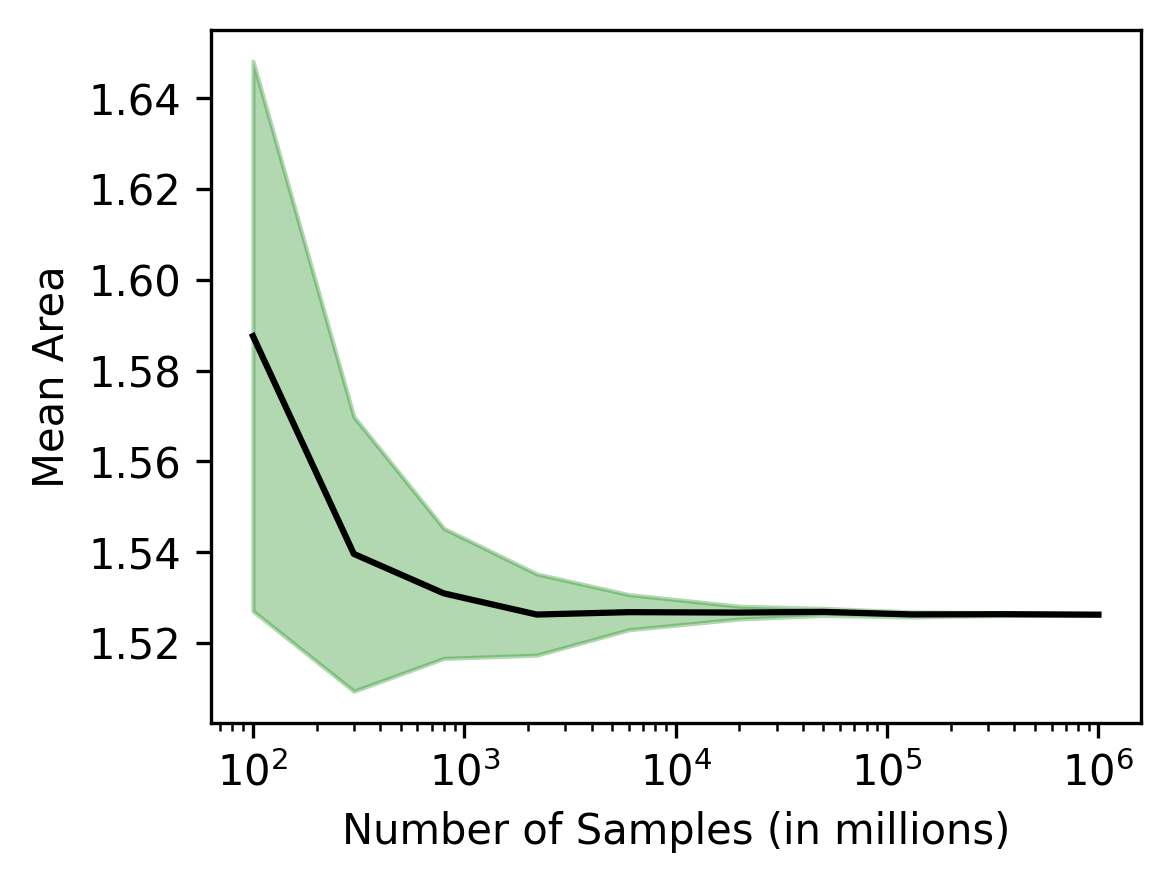

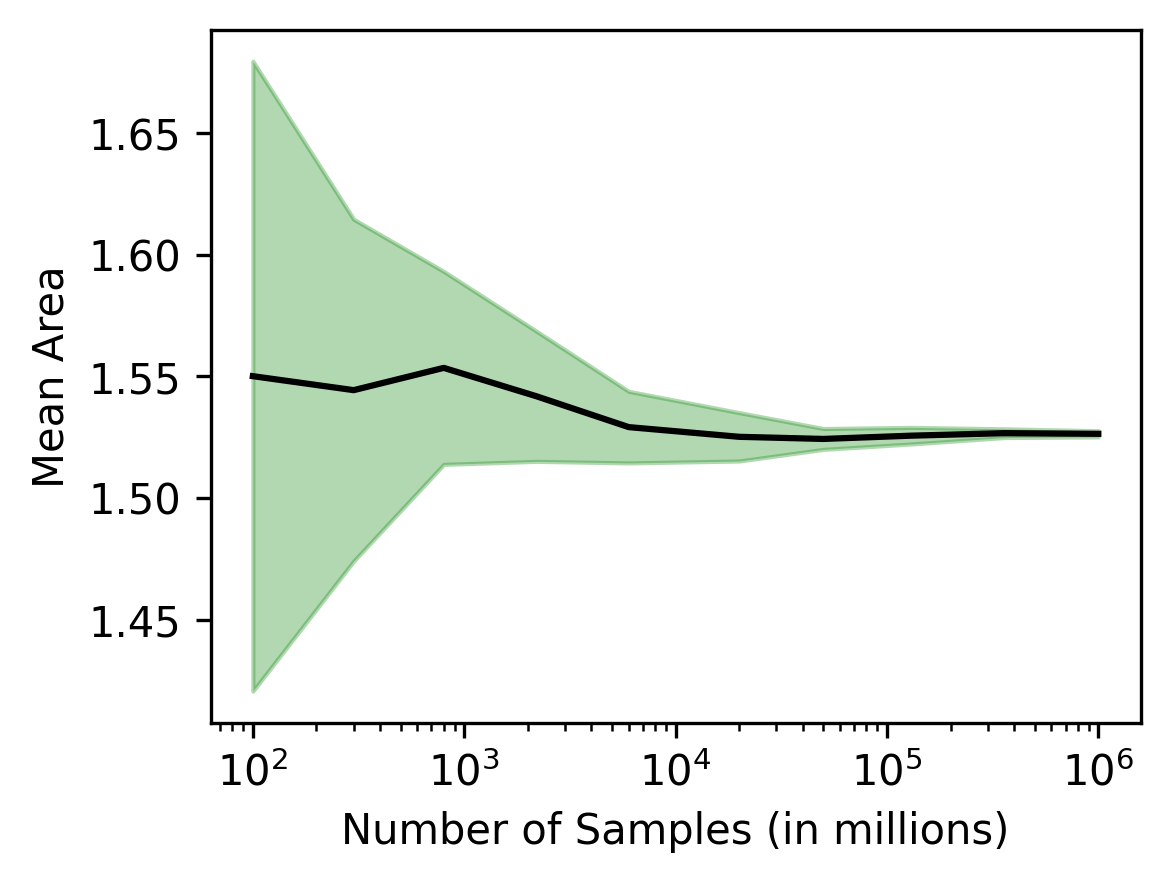

In [34]:
for sampling in s_sampling_results:
    analyse2(s_sampling_results[sampling], s_range)
    # analyse(i_sampling_results[sampling], iter_range, 'i')

In [35]:
if __name__ == "__main__":
    s = 100000
    
    chunks = 25
    
    min_iter = 75
    max_iter = 1500
    steps = 20
    
    max_iters = np.full(chunks, max_iter)
    s_list = np.full(chunks, s)

    iter_range = np.linspace(min_iter, max_iter, steps, dtype=int)
    iter_ranges = np.repeat([iter_range], chunks, axis=0)
    print(iter_range)


    i_sampling_results = {}


    for sampling in ['ortho', 'importance']:

        # independent seeds necessary for parallel processing
        seq = np.random.SeedSequence()
        sequences = seq.spawn(chunks)
        samplings = np.full(chunks, sampling)
        args = list(zip(s_list, iter_ranges, sequences, samplings))
        
        with Pool() as p:
            results =  np.array(p.starmap(converge_i, args))
        
        i_data = [None] * steps
        for step in range(steps):
            i_data[step] = results[:,step, 1]
        i_sampling_results[sampling] = i_data

[  75  176  278  380  482  583  685  787  889  991 1092 1194 1296 1398
 1500]


In [ ]:
for sampling in i_sampling_results:
    analyse(s_sampling_results[sampling], s_range, 's')
    analyse(i_sampling_results[sampling], iter_range, 'i')


In [ ]:
# visualise(data, max_iter)